In [1]:
# univariate cnn example
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

**Example Simple**

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [3]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
print('X:', X)
print('y:', y)

X: [[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]]
y: [40 50 60 70 80 90]


In [4]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

**First model**

In [5]:
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
_________________________________________________________________


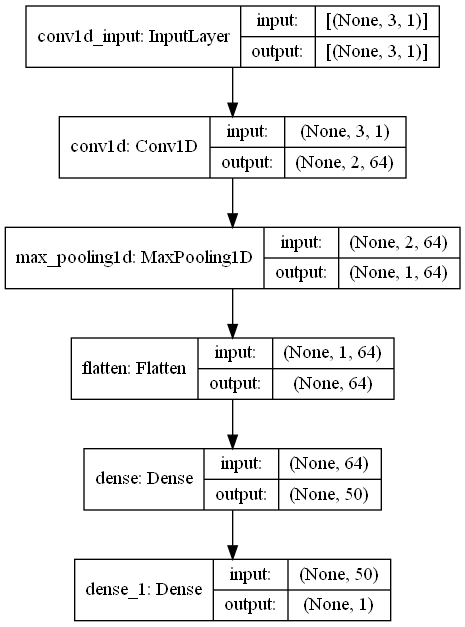

In [6]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
# define model
# fit model
history = model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.60538]]


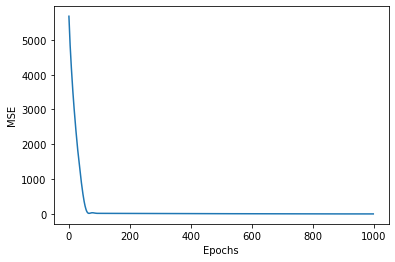

In [8]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(history.history['loss'])

In [9]:
history.history['loss'][-1]

0.13719159364700317

In [10]:
model_tcn = keras.models.Sequential()
model_tcn.add(keras.layers.InputLayer(input_shape=[n_steps, 1]))
for dilation_rate in (1, 2, 4):
    model_tcn.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model_tcn.add(keras.layers.Conv1D(filters=64, kernel_size=1))
model_tcn.add(keras.layers.MaxPooling1D(pool_size=2))
model_tcn.add(keras.layers.Flatten())
model_tcn.add(keras.layers.Dense(50, activation='relu'))
model_tcn.add(keras.layers.Dense(1))
model_tcn.compile(optimizer='adam', loss='mae')

In [11]:
# define model
# fit model
history = model_tcn.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_tcn.predict(x_input, verbose=0)
print(yhat)

[[100.64714]]


**Google Example**

In [12]:
df = pd.read_csv('Google_Close.csv')
close_seq = df['Close'].values
samples = close_seq.size

**X_Train_Google**

In [13]:
pd.options.plotting.backend = "plotly"
df.plot(x='Date', y='Close')

In [14]:
X_Google, Y_Google = split_sequence(close_seq, n_steps)

In [15]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_Google = X_Google.reshape((X_Google.shape[0], X_Google.shape[1], n_features))
X_Google.shape

(1486, 3, 1)

In [16]:
# fit the model
history_google = model.fit(X_Google, Y_Google, epochs=1000, verbose=0)

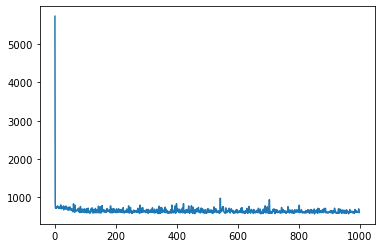

In [17]:
# visualizing losses and accuracy
train_loss = history_google.history['loss']
plt.plot(train_loss)

In [18]:
train_loss[-1]

601.298095703125

In [19]:
# demonstrate prediction
X_Google_test = close_seq[samples-3:]
X_Google_test = X_Google_test.reshape((1, n_steps, n_features))
yhat_Google = model.predict(X_Google_test, verbose=0)
print(yhat_Google)

[[2861.6587]]


**Test:** 

In [20]:
import pandas_datareader as data
data_source = 'yahoo'
start_date = '2021-11-30'
end_date = '2022-01-01'
Google_test = data.DataReader('GOOG', data_source, start_date, end_date)

In [21]:
pd.options.plotting.backend = "plotly"
Google_test.plot(y=['Close'])

In [22]:
print("30 November:" ,close_seq[-1])
print("Prediction 1 December:", yhat_Google[0][0])
print('Real value 1 December:', Google_test['Close'].iloc[1])

30 November: 2849.0400390625
Prediction 1 December: 2861.6587
Real value 1 December: 141.6179962158203


In [23]:
X_test, Y_test = split_sequence(Google_test['Close'].values, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_test.shape

(20, 3, 1)

In [24]:
import plotly.express as px
Y_hat_test = []
for x in X_test:
    x = x.reshape(1, n_steps, n_features)
    Y_hat_test.append(model.predict(x, verbose=0))
Y_hat_test = np.array(Y_hat_test).reshape(X_test.shape[0])
fig = px.line(y=[Y_hat_test, Y_test])
newnames = {'wide_variable_0':'Y_predicted', 'wide_variable_1': 'Y_test'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                     hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                   )
                  )
fig.show()

**Improving the model**

In [25]:
model_google = keras.Sequential()
model_google.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_google.add(keras.layers.Flatten())
model_google.add(keras.layers.Dense(50, activation='relu'))
model_google.add(keras.layers.Dense(1))
model_google.compile(optimizer='adam', loss='mse')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 1, 128)            512       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 7,013
Trainable params: 7,013
Non-trainable params: 0
_________________________________________________________________


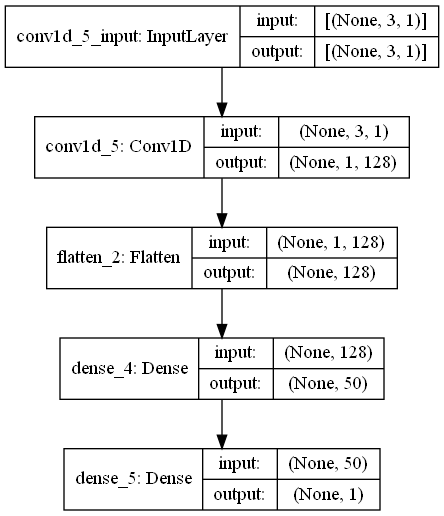

In [26]:
model_google.summary()
tf.keras.utils.plot_model(model_google, show_shapes=True)

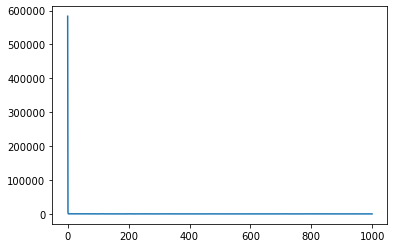

In [27]:
# fit the model
history_google_prime = model_google.fit(X_Google, Y_Google, epochs=1000, verbose=0)
# visualizing losses and accuracy
train_loss_prime = history_google_prime.history['loss']
plt.plot(train_loss_prime)

In [28]:
train_loss_prime[-1]

573.0552368164062

In [29]:
Y_hat_test_prime = []
for x in X_test:
    x = x.reshape(1, n_steps, n_features)
    Y_hat_test_prime.append(model_google.predict(x, verbose=0))
Y_hat_test_prime = np.array(Y_hat_test_prime).reshape(X_test.shape[0])
fig = px.line(y=[Y_hat_test_prime, Y_test])
newnames = {'wide_variable_0':'Y_predicted', 'wide_variable_1': 'Y_test'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                     hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                   )
                  )
fig.show()